## Spatial Validation for Census Points & Polygons
_Latitude and Longitude coordinates provided by the Census should fall inside polygons provided by the Census, right?_

In [1]:
%matplotlib inline

# required packages, also need run homebrew for spatial join to work! 
# brew install spatialindex
#!pip3 install geopandas descartes matplotlib shapely rtree

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely import geometry, wkt
from shapely.geometry import Point

### Load Gazetteer Locations

  USPS   GEOID  ANSICODE                NAME  LSAD FUNCSTAT      ALAND  \
0   CA  600135   2582926  Acalanes Ridge CDP    57        S    1193072   
1   CA  600156   2629758          Acampo CDP    57        S    2428474   
2   CA  600212   2407697           Acton CDP    57        S  101679341   
3   CA  600296   2409663       Adelanto city    25        A  137220853   
4   CA  600310   2582927            Adin CDP    57        S    8901691   

   AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT   INTPTLONG  
0       0       0.461        0.000  37.904722 -122.078574  
1       0       0.938        0.000  38.173529 -121.279892  
2   60418      39.259        0.023  34.496070 -118.183897  
3   45848      52.981        0.018  34.580902 -117.439458  
4   15858       3.437        0.006  41.199312 -120.956779  


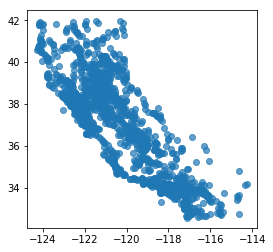

In [3]:
# CSV converted from https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2017_Gazetteer/2017_gaz_place_06.txt
census_gaz = pd.read_csv("data/2017_gaz_place_06.csv")
print(census_gaz.head())

# combine coordinates
census_gaz['Coordinates'] = list(zip(census_gaz.INTPTLONG, census_gaz.INTPTLAT))
census_gaz['Coordinates'] = census_gaz['Coordinates'].apply(Point)

# convert to Pandas Geospatial Dataframe
census_gaz_points = gpd.GeoDataFrame(census_gaz, geometry='Coordinates')

# plot the points!
census_gaz_points.plot(alpha=.7)

### Load Cartographic Boundary Shapefile
https://www.census.gov/geo/maps-data/data/cbf/cbf_place.html

  STATEFP PLACEFP   PLACENS          AFFGEOID    GEOID           NAME LSAD  \
0      06   66000  02411782  1600000US0666000  0666000      San Diego   25   
1      06   48354  02411130  1600000US0648354  0648354        Modesto   25   
2      06   78582  02412065  1600000US0678582  0678582  Thousand Oaks   25   
3      06   17498  02410272  1600000US0617498  0617498         Cudahy   25   
4      06   21712  02410406  1600000US0621712  0621712       El Cajon   25   

       ALAND     AWATER                                           geometry  
0  841108238  122244240  (POLYGON ((-116.93264 32.649128, -116.931919 3...  
1  111280668    4768868  (POLYGON ((-121.07441 37.699985, -121.068995 3...  
2  143118041     387875  (POLYGON ((-118.911435 34.171963, -118.909328 ...  
3    3043278     131925  POLYGON ((-118.201898 33.970611, -118.199612 3...  
4   37516313          0  POLYGON ((-117.011281 32.820275, -117.005763 3...  


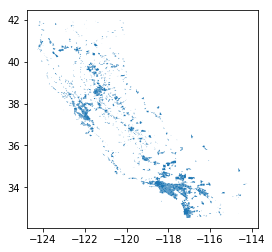

In [5]:
# downloaded from http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_06_place_500k.zip
census_cb = gpd.read_file("data/cb_2017_06_place_500k/cb_2017_06_place_500k.shp")
print(census_cb.head())

# plot the polygons!
census_cb.plot()

### Load TIGER/Line® Shapefile
https://www.census.gov/cgi-bin/geo/shapefiles/index.php

  STATEFP PLACEFP   PLACENS    GEOID              NAME               NAMELSAD  \
0      06   38520  02411544  0638520         King City         King City city   
1      06   86300  02412299  0686300          Woodlake          Woodlake city   
2      06   80994  02412119  0680994  Twentynine Palms  Twentynine Palms city   
3      06   81344  02412137  0681344            Upland            Upland city   
4      06   87042  02412326  0687042           Yucaipa           Yucaipa city   

  LSAD CLASSFP PCICBSA PCINECTA  MTFCC FUNCSTAT      ALAND   AWATER  \
0   25      C1       N        N  G4110        A   10090834   222052   
1   25      C1       N        N  G4110        A    6305660  1178472   
2   25      C1       N        N  G4110        A  152179753        0   
3   25      C1       N        N  G4110        A   40432020    86983   
4   25      C1       N        N  G4110        A   73279143        0   

      INTPTLAT      INTPTLON  \
0  +36.2162833  -121.1319616   
1  +36.4128251  -119.0

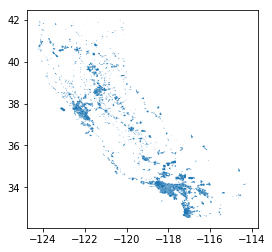

In [6]:
# downloaded/extracted from ftp://ftp2.census.gov/geo/tiger/TIGER2018/PLACE/tl_2018_06_place.zip
census_tl = gpd.read_file("data/tl_2018_06_place/tl_2018_06_place.shp")
print(census_tl.head())

# plot the polygons!
census_tl.plot()

### Merge Cartographic Boundary with Gazetteer

***Note that `sjoin` will return an error referencing `libspatialindex` if you have not used homebrew to install `spatialindex` as this is a requirement of [rtree](https://pypi.org/project/Rtree/)***

In [7]:
# coordinate reference system warning averted!
census_gaz_points.crs = census_cb.crs
cenus_gaz_points_cb = gpd.sjoin(census_gaz_points, census_cb, how="left", op='intersects')

# check for non-joined geographies
cenus_gaz_points_cb_unjoined = cenus_gaz_points_cb[cenus_gaz_points_cb.GEOID_right.isnull()]
cenus_gaz_points_cb_unjoined

,USPS,GEOID_left,ANSICODE,NAME_left,LSAD_left,FUNCSTAT,ALAND_left,AWATER_left,ALAND_SQMI,AWATER_SQMI,...,index_right,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID_right,NAME_right,LSAD_right,ALAND_right,AWATER_right
333,CA,617918,2410291,Daly City city,25,A,19789731,0,7.641,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,CA,626000,2410545,Fremont city,25,A,200632981,26291597,77.465,10.151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1193,CA,667000,2411786,San Francisco city,25,A,121485107,479107241,46.906,184.984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296,CA,673262,2411942,South San Francisco city,25,A,23769809,54435146,9.178,21.018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge TIGER/Line® Shapefile with Gazetteer

In [8]:
# coordinate reference system warning averted!
census_gaz_points.crs = census_tl.crs
cenus_gaz_points_tl = gpd.sjoin(census_gaz_points, census_tl, how="left", op='intersects')

# check for non-joined geographies
cenus_gaz_points_tl_unjoined = cenus_gaz_points_tl[cenus_gaz_points_tl.GEOID_right.isnull()]
cenus_gaz_points_tl_unjoined

,USPS,GEOID_left,ANSICODE,NAME_left,LSAD_left,FUNCSTAT_left,ALAND_left,AWATER_left,ALAND_SQMI,AWATER_SQMI,...,LSAD_right,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT_right,ALAND_right,AWATER_right,INTPTLAT_right,INTPTLON


## What are the FIPs codes for Points not found in Cartographic Boundary shapefile?

In [9]:
for idx,row in cenus_gaz_points_cb_unjoined.iterrows():
    geoid = row['GEOID_left']
    name = row['NAME_left']
    print(geoid,str(name))

617918 Daly City city
626000 Fremont city
667000 San Francisco city
673262 South San Francisco city


## Filter both shapefiles for 4 places

In [10]:
census_cb_test = census_cb
census_cb_test = census_cb_test.query('GEOID in ("0667000","0617918","0626000","0673262")')
census_cb_test

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
297,06,26000,02410545,1600000US0626000,0626000,Fremont,25,200632981,26291597,"POLYGON ((-122.130211 37.563942, -122.124954 3..."
390,06,67000,02411786,1600000US0667000,0667000,San Francisco,25,121485107,479107241,"(POLYGON ((-122.332045780727 37.7877603470098,..."
393,06,73262,02411942,1600000US0673262,0673262,South San Francisco,25,23769809,54435146,"POLYGON ((-122.47076 37.649406, -122.469055 37..."
719,06,17918,02410291,1600000US0617918,0617918,Daly City,25,19789731,0,"POLYGON ((-122.50052918554 37.7008353023262, -..."


In [11]:
census_tl_test = census_tl
census_tl_test = census_tl_test.query('GEOID in ("0667000","0617918","0626000","0673262")')
census_tl_test

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
205,06,67000,02411786,0667000,San Francisco,San Francisco city,25,C1,Y,N,G4110,A,121375681,479216672,+37.7272391,-123.0322294,"(POLYGON ((-122.612285 37.815224, -122.584588 ..."
302,06,17918,02410291,0617918,Daly City,Daly City city,25,C1,N,N,G4110,A,19789734,0,+37.7008350,-122.5007910,"POLYGON ((-122.500791 37.700835, -122.499925 3..."
304,06,73262,02411942,0673262,South San Francisco,South San Francisco city,25,C1,Y,N,G4110,A,23893943,54315250,+37.6551037,-122.3762341,"POLYGON ((-122.471733 37.649159, -122.471517 3..."
479,06,26000,02410545,0626000,Fremont,Fremont city,25,C1,N,N,G4110,A,200632981,26291597,+37.5010483,-122.0839341,"POLYGON ((-122.149175 37.545835, -122.135769 3..."


## Transform for Socrata Spatial Success
- Convert Polygons to Multipolygons
- Save as GEOJSON files

In [12]:
#Handy function provided by https://github.com/geopandas/geopandas/issues/834
upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
                   geometry.LineString: geometry.MultiLineString, 
                   geometry.Polygon: geometry.MultiPolygon}

def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])

census_tl.geometry = census_tl.geometry.apply(maybe_cast_to_multigeometry)
census_cb.geometry = census_cb.geometry.apply(maybe_cast_to_multigeometry)

In [ ]:
# Convert to GEOJSON
census_tl.to_file("~/data/tl_2018_06_place.json", driver="GeoJSON")
census_cb.to_file("~/data/cb_2018_06_place.json", driver="GeoJSON")

/usr/local/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Visually inspect unjoined cities
- Plot point on polygon for the GEOID
- Get centroid of polygon
- Plot centroid
- Confirm spatial join between polygon and centroid